### The following notebook requires the summit_utils module which is available here: https://github.com/lsst-sitcom/summit_utils.git, be sure to check out branch tickets/DM-31175.

### As of November 3, one needs to run version w_2022_44 of lsst_distrib.

In [1]:
from lsst.summit.utils.utils import checkStackSetup, getExpPositionOffset
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import numpy as np
from lsst.summit.utils.blindSolving import blindSolve, chuckHeaderToWcs, headerToWcs, runImchar
import lsst.afw.image as afwImage
import glob
%matplotlib inline
%env ASTROMETRY_NET_API_KEY=jsnplwndlgndoouk
checkStackSetup()

env: ASTROMETRY_NET_API_KEY=jsnplwndlgndoouk
You are running w_2022_44 of lsst_distrib

Locally setup packages:
-----------------------
summit_utils at /home/adriansh95/software/summit_utils


In [2]:
homePath = '/home/adriansh95' # Adrian at Summit
dataPath = 'data/starTracker/tmaTests' # Adrian at Summit and USDF
tmaTestsPath = os.path.join(homePath, dataPath) 
imageDir = 'procFits'
wcsDir = 'wcsFits'
imagePath = os.path.join(tmaTestsPath, imageDir, '*.fits') 
wcsPath = os.path.join(tmaTestsPath, wcsDir)
passPath = os.path.join(wcsPath, 'pass')
failPath = os.path.join(wcsPath, 'fail')
files = glob.glob(imagePath)
files = natsorted(files)
print(f"Found {len(files)} files")

Found 99 files


### Loop over files, solving for the wcs using astrometry.net. Inspect and verify by eye that the images do not appear saturated. Write WCSs to pass or fail directory

Found 200 sources, 200 bright sources
Brightest centroid at (2502.8355475245676, 15.424371417540591)
Got nan for ra/dec from visitInfo, using ra/dec from wcs...
Solving..........Finished solving!


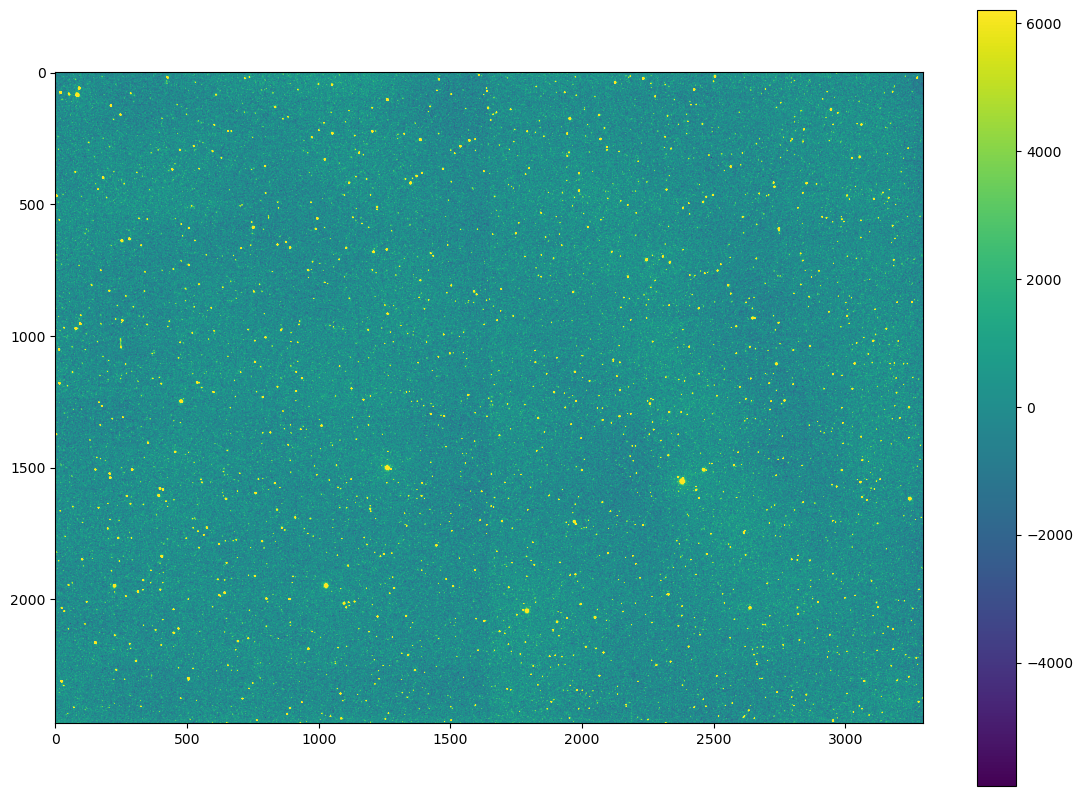

Do any sources look saturated? (y/n) n


Image acceptable. Proceed.
Wrote /home/adriansh95/data/starTracker/tmaTests/wcsFits/pass/P1_10sec_2.fits


In [3]:
stopImage = 1
for filename in files[:stopImage]:
    stemName = os.path.basename(filename).split('.')[0]
    imageAcceptable = True
    exp = afwImage.ExposureF(filename)
    nominalWcs = chuckHeaderToWcs(exp)
    exp.setWcs(nominalWcs)
    result = blindSolve(exp, radiusInDegrees=30)
    mean = np.mean(exp.image.array)
    std = np.std(exp.image.array)
    plt.figure(figsize=(14, 14))

    while True:
        plt.imshow(exp.image.array, vmin=mean-2*std, vmax=mean+2*std)
        plt.colorbar(shrink=0.72)
        plt.show()
        saturatedStars = input('Do any sources look saturated? (y/n)')
        if saturatedStars == 'y':
            imageAcceptable = False
            break
        elif saturatedStars == 'n':
            break
        else:
            print('Invalid input. (y/n)')
            continue

    if imageAcceptable:
        writeTo = os.path.join(passPath, f'{stemName}.fits')
        print('Image acceptable. Proceed.')
    else:
        print('Image unacceptable. Stop and explain failure')
        writeTo = os.path.join(failPath, f'{stemName}.fits')
    
    exp.writeFits(writeTo)
    print(f'Wrote {writeTo}')